# Two Spirals

This notebook explores the two-spirals category task. This is a good example of how to make a problem difficult for humans and neural networks.

In [1]:
import conx as cx
import math

Using TensorFlow backend.
Conx, version 3.6.1


This task involves separating two categories, A and B, where the two sets spiral around each other.

First, let's make the dataset:

In [2]:
def spiral_xy(i, spiral_num):
    """
    Create the data for a spiral. 
    
    Arguments:
        i runs from 0 to 96
        spiral_num is 1 or -1
    """
    φ = i/16 * math.pi
    r = 6.5 * ((104 - i)/104)
    x = (r * math.cos(φ) * spiral_num)/13 + 0.5
    y = (r * math.sin(φ) * spiral_num)/13 + 0.5
    return (x, y)

def spiral(spiral_num):
    return [spiral_xy(i, spiral_num) for i in range(97)]

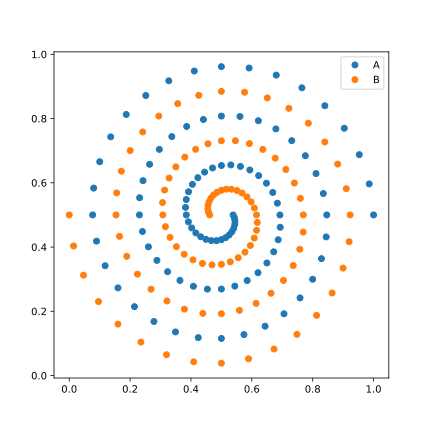

In [3]:
a = ["A", spiral(1)]
b = ["B", spiral(-1)]

cx.scatter([a,b])

So, there it is: given the (x,y) coordinates of a point, can you determine if it belongs to category A or B. This is fairly easy to do given the picture. But very difficult only given the coordinates.

Nonetheless, this was an early challenge problem for neural networks, and much research was done in order to learn the task.

Many things were tried, with various levels of success!

For an overview of the task, and solutions see, for example:

https://www.researchgate.net/publication/220233514_Variations_of_the_two-spiral_task

Here is an attempt using so-called "shortcut" connections:

In [15]:
net = cx.Network("Two-Spirals")
net.add(
    cx.Layer("input", 2),
    cx.Layer("hidden3", 5, activation="sigmoid"),
    cx.Layer("hidden2", 5, activation="sigmoid"),
    cx.Layer("hidden1", 5, activation="sigmoid"),
    cx.Layer("output", 2, activation="softmax")
)
net.connect("input", "hidden1")
net.connect("hidden2", "hidden3")
net.connect("hidden3", "output")
net.connect("hidden1", "output")
net.connect("hidden1", "hidden2")
net.connect("hidden1", "hidden3")
net.connect("hidden2", "output")
net.compile(error="categorical_crossentropy", optimizer="rmsprop")

In [16]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 2)            0                                            
__________________________________________________________________________________________________
hidden1 (Dense)                 (None, 5)            15          input[0][0]                      
__________________________________________________________________________________________________
hidden2 (Dense)                 (None, 5)            30          hidden1[0][0]                    
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 10)           0           hidden2[0][0]                    
                                                                 hidden1[0][0]                    
__________

In [17]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=4, options=('input', 'hidden3', 'hidden2', 'hidden1', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

In [14]:
net.dataset.load([(xy, [0, 1]) for xy in spiral(1)] +
                 [(xy, [1, 0]) for xy in spiral(-1)])

In [8]:
net.reset()

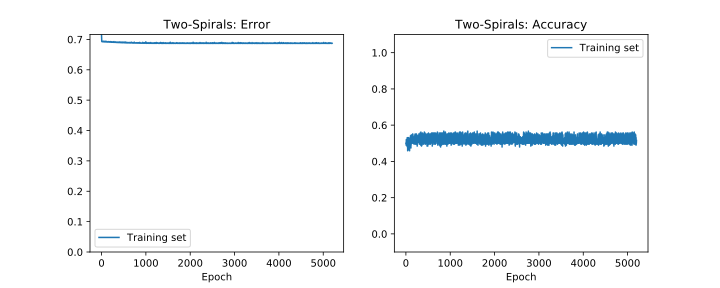

In [ ]:
net.train(10000, report_rate=100, batch_size=32, accuracy=1.0, tolerance=0.1)

However, I could never learn to do the task. Perhaps you can find some parameters that will work.

Or, perhaps we can just make this much easier for the neural network.

## Picture-based Approach

In this formulation, we create "images" for each input and use a Convolutional layer.

In [19]:
import conx as cx
import copy

We need to pick a resolution for the images. We chop up the input space into a 50 x 50 images.

In [20]:
RESOLUTION = 50

In [21]:
def make_picture(res):
    matrix = [[0.0 for i in range(res)]
              for j in range(res)]
    for x,y in spiral(1):
        x = min(int(round(x * res)), res - 1)
        y = min(int(round(y * res)), res - 1)
        matrix[1 - y][x] = 0.5
    for x,y in spiral(-1):
        x = min(int(round(x * res)), res - 1)
        y = min(int(round(y * res)), res - 1)
        matrix[1 - y][x] = 0.5
    return matrix

In [22]:
matrix = make_picture(RESOLUTION)

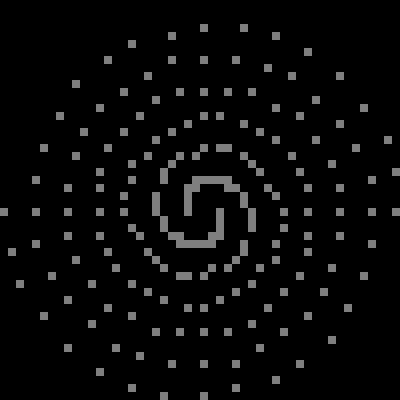

In [23]:
cx.array_to_image(matrix, shape=(RESOLUTION,RESOLUTION,1)).resize((400,400))

In this example, we have three values:

* background - 0.0
* other data - 0.5
* the target - 1.0

We could might be able to leave out the other data, but that seemed to make it more difficult. We want to let the network "see" the pattern.

In [24]:
def make_data(res):
    data = []
    for x,y in spiral(1):
        x = min(int(round(x * res)), res - 1)
        y = min(int(round(y * res)), res - 1)
        inputs = copy.deepcopy(matrix)
        inputs[1 - y][x] = 1.0
        inputs = cx.reshape(inputs,(50,50,1))
        data.append([inputs, [0, 1]])
    for x,y in spiral(-1):
        x = min(int(round(x * res)), res - 1)
        y = min(int(round(y * res)), res - 1)
        inputs = copy.deepcopy(matrix)
        inputs[1 - y][x] = 1.0
        inputs = cx.reshape(inputs,(50,50,1))
        data.append([inputs, [1, 0]])
    return data

In [25]:
data = make_data(RESOLUTION)

We create the simplest form of a Conv2DLayer network:

In [26]:
net = cx.Network("Two-Spirals using Pictures")
net.add(
    cx.ImageLayer("input", (RESOLUTION, RESOLUTION), 1),
    cx.Conv2DLayer("conv2d", 2, 4),
    cx.FlattenLayer("flatten"),
    cx.Layer("output", 2, activation="softmax")
)
net.connect()
net.compile(error="categorical_crossentropy", optimizer="rmsprop")

In [27]:
net.dataset.load(data)

In [28]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'input', 'conv2d'), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=3, options=('input', 'conv2d', 'flatten', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

And try training it:

In [22]:
net.reset()

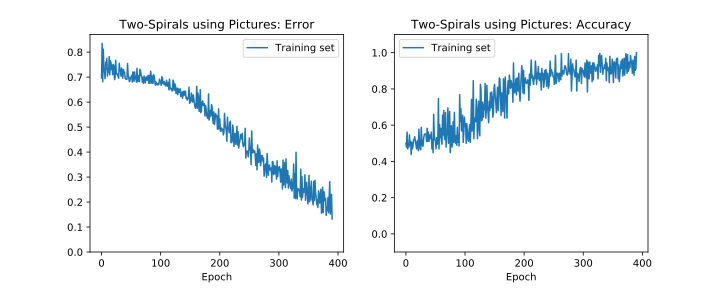

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  390 |   0.13236 |   1.00000 


In [23]:
net.train(1000, accuracy=1.0, report_rate=10)

It worked! This makes the task easy. 

Let's take a look at the generalization capability of the network by creating images that it wasn't trained on over the 50 x 50 space:

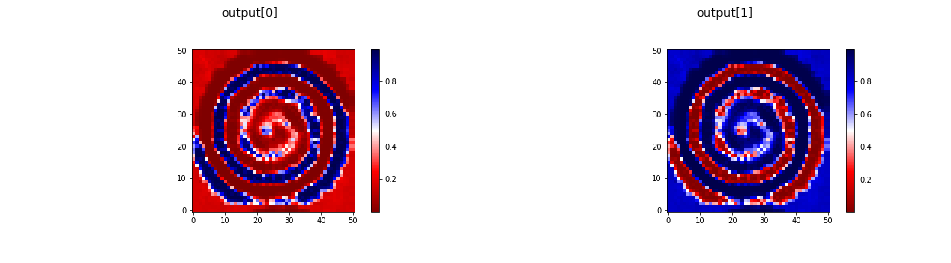

In [24]:
def test0(x, y, res=RESOLUTION):
    x = min(int(round(x * res)), res - 1)
    y = min(int(round(y * res)), res - 1)
    inputs = copy.deepcopy(matrix)
    inputs[1 - y][x] = 1.0
    inputs = cx.reshape(inputs,(50,50,1))
    return net.propagate(inputs)[0]

def test1(x, y, res=RESOLUTION):
    x = min(int(round(x * res)), res - 1)
    y = min(int(round(y * res)), res - 1)
    inputs = copy.deepcopy(matrix)
    inputs[1 - y][x] = 1.0
    inputs = cx.reshape(inputs,(50,50,1))
    return net.propagate(inputs)[1]

cx.view([cx.heatmap(test0, format="image"), cx.heatmap(test1, format="image")], 
        labels=["output[0]","output[1]"], scale=7.0)

Sometimes it creates fairly smooth spirals. However, other times, it may just "memorize" the problem, with no particular pattern. Which do you get?